In [34]:
"Importing necessary packages."

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [35]:
"Creating a function with known first and second order derivatives and random paramters to generate training data."

class TrainingFunc():
  def __init__(self):
    self.val = np.random.uniform(0.5, 2, 2)
    self.sqrtv = np.sqrt(self.val[0])
    self.step = np.random.uniform(0.001, 0.019)
    
  def pos(self, x): return self.val[1] * np.sin(self.sqrtv * x)
  def vel(self, x): return self.val[1] * self.sqrtv * np.cos(self.sqrtv * x)
  def acc(self, x): return -self.val[1] * self.val[0] * np.sin(self.sqrtv * x)

In [36]:
abba = TrainingFunc()
print(abba.step)
abba.pos(abba.step)
abba.vel(abba.step)

0.011030576272428164


2.0740389220833393

In [37]:
"Generating the training data"

ini_training_func = TrainingFunc()

input_data = [[ini_training_func.step, ini_training_func.pos(0), 
                         ini_training_func.vel(0), ini_training_func.acc(0)]]

target_data = [[ini_training_func.pos(ini_training_func.step), 
                          ini_training_func.vel(ini_training_func.step)]]

for i in range(15_000_000):
  new_training_func = TrainingFunc()
  randx = np.random.uniform(-1, 1)

  new_input_data = [new_training_func.step, new_training_func.pos(randx), 
                         new_training_func.vel(randx), new_training_func.acc(randx)]
  
  new_target_data = [new_training_func.pos(randx + new_training_func.step), 
                          new_training_func.vel(randx + new_training_func.step)]
  
  input_data.append(new_input_data)
  target_data.append(new_target_data)

input_data = np.array(input_data)
target_data = np.array(target_data)

In [38]:
"Defining the model."

np.random.seed(13)

num_inputs = 4
num_hidden = 3
num_outputs = 2

graph = tf.Graph()

with graph.as_default():
  inputs = tf.placeholder(tf.float32, shape=[None, num_inputs])
  targets = tf.placeholder(tf.float32, shape=[None, num_outputs])

  hidden_weights = tf.Variable(tf.truncated_normal([num_inputs + 1, num_hidden]))
  hidden_biases = tf.Variable(tf.zeros([1, num_hidden]))

  output_weights = tf.Variable(tf.truncated_normal([num_hidden + 1, num_outputs]))
  output_biases = tf.Variable(tf.zeros([1, num_outputs]))

  hidden_layer = tf.nn.dropout(tf.nn.relu(tf.matmul(tf.concat([inputs, tf.ones([tf.shape(inputs)[0], 1])], axis=1), hidden_weights) + hidden_biases), rate=0.5)
  output_layer = tf.matmul(tf.concat([hidden_layer, tf.ones([tf.shape(inputs)[0], 1])], axis=1), output_weights) + output_biases

  loss = tf.reduce_mean(tf.square(targets - output_layer))
  optimizer = tf.train.AdamOptimizer().minimize(loss)

  init = tf.global_variables_initializer()

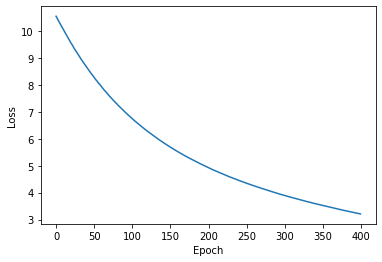

In [39]:
"Training the model."

with tf.Session(graph=graph) as sess:
  sess.run(init)

  noisy_input_data = input_data + np.random.normal(scale=0.0001, size=input_data.shape)

  losses = []
  for i in range(400):
      _, loss_val = sess.run([optimizer, loss], feed_dict={inputs: noisy_input_data, targets: target_data})
      losses.append(loss_val)
      
  saver = tf.train.Saver()
  save_path = saver.save(sess, "my_model.ckpt")

  plt.plot(losses)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

[[-0.29571867 -0.98999906]]


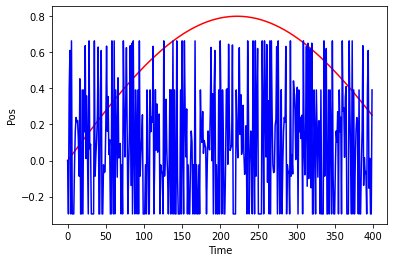

In [40]:
"Testing the model on a simple harmonic oscillator."

class Oscillator:
  def __init__(self, a, h):
    self.a = a
    self.sqrta = np.sqrt(a)
    self.ini = np.array([h, 0, self.sqrta, 0])

  def acc(self, pos):
    return 0.8 * self.a * np.sin(pos)

  def vel(self, t):
    return 0.8 * self.sqrta * np.cos(self.sqrta * t)

  def pos(self, t):
    return 0.8 * np.sin(self.sqrta * t)

h = 0.01
a = 0.5
oscillator = Oscillator(a, h)
exact_sol = [oscillator.ini[1]]
model_sol = [oscillator.ini[1]]

with tf.Session(graph=graph) as sess:
  saver = tf.train.Saver()
  saver.restore(sess, "my_model.ckpt")

  prediction = sess.run(output_layer, feed_dict={inputs: oscillator.ini.reshape((1, 4))})
  print(prediction)
  model_sol.append(prediction[0,0])
  exact_sol.append(oscillator.pos(h))

  for i in range(2, 400):
   exact_sol.append(oscillator.pos(i * h))
   input_data = np.array([h, prediction[0,0], prediction[0,1], oscillator.acc(prediction[0,0])]).reshape((1, 4))
   prediction = sess.run(output_layer, feed_dict={inputs: input_data})
   model_sol.append(prediction[0,0])

plt.plot(exact_sol, 'r')
plt.plot(model_sol, 'b')
plt.xlabel("Time")
plt.ylabel("Pos")
plt.show()